In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout, BatchNormalization, SimpleRNN, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import datetime
import math

In [218]:
link = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(link)
df.shape
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [222]:
df = df['Passengers']
df = np.array(df).reshape(-1,1)

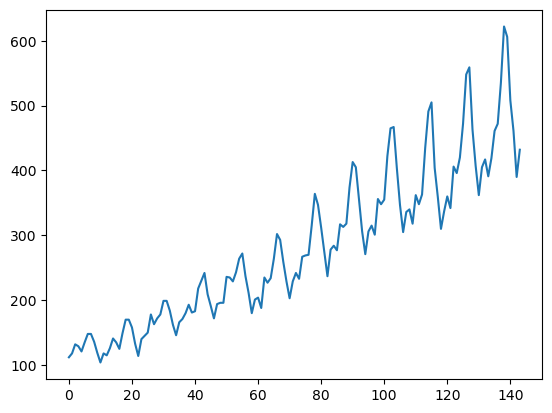

In [224]:
plt.plot(df)
plt.show()

In [225]:
#Min Max Scaler
scaler= MinMaxScaler()
data=scaler.fit_transform(df)

In [226]:
print(data.shape)

(144, 1)


In [227]:
train_size = 100
test_size = 44
train, test = data[0:train_size,:], data[train_size:len(data),:]

print(train.shape)
print(test.shape)


(100, 1)
(44, 1)


In [228]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [229]:
# reshape into X=t and Y=t+1
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [230]:
# reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


LSTM MODEL

In [237]:
#LSTM model
lstm=Sequential()
lstm.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm.add(LSTM(units=32, return_sequences=True))
lstm.add(LSTM(units=32, return_sequences=True))
lstm.add(LSTM(units=32))
lstm.add(Dense(units=1))
lstm.compile(optimizer='adam', loss='mean_squared_error')
lstm.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1, 32)             4352      
                                                                 
 lstm_18 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_19 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_20 (LSTM)              (None, 32)                8320      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [238]:
lstm.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 1, 32)             4352      
                                                                 
 lstm_18 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_19 (LSTM)              (None, 1, 32)             8320      
                                                                 
 lstm_20 (LSTM)              (None, 32)                8320      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [249]:
history_LSTM = lstm.fit(X_train, y_train, epochs=100, batch_size=1, validation_split=0.2)

Epoch 1/100
78/78 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 2/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0056
Epoch 3/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0019 - val_loss: 0.0043
Epoch 4/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 5/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 6/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0050
Epoch 7/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 8/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 9/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 10/100
78/78 [==============================] - 0s 3ms/step - loss: 0.0017 - val_loss: 0.0039
Epoch 11/

2/2 [==============================] - 0s 3ms/step
Train Score: 23.75 RMSE
Test Score: 68.60 RMSE


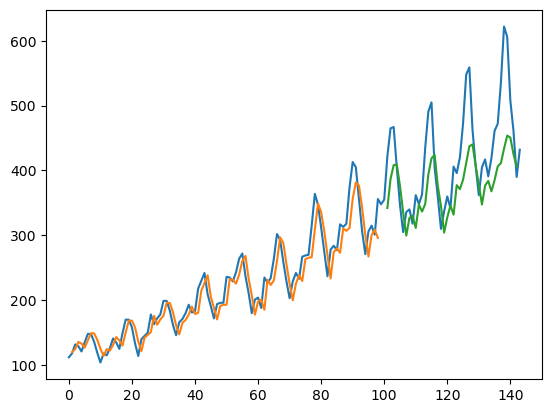

In [256]:
# make predictions
trainPredict = lstm.predict(X_train)
testPredict = lstm.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
lstm_y_pred = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = np.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mse(testY[0], lstm_y_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = lstm_y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

RNN MODEL

In [251]:
rnn = Sequential()
rnn.add(SimpleRNN(units = 100,activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn.add(Dropout(0.2))
rnn.add(SimpleRNN(units = 80,activation='relu', return_sequences = True))
rnn.add(Dropout(0.2))
rnn.add(SimpleRNN(units = 20))
rnn.add(Dropout(0.2))
rnn.add(Dense(units = 1))
rnn.compile(optimizer = 'adam', loss = 'mse')

history_rnn = rnn.fit(X_train, y_train, epochs = 100, batch_size = 50, validation_split=0.2)

Epoch 1/100
2/2 [==============================] - 3s 326ms/step - loss: 0.0391 - val_loss: 0.1341
Epoch 2/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0242 - val_loss: 0.0848
Epoch 3/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0116 - val_loss: 0.0473
Epoch 4/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0092 - val_loss: 0.0227
Epoch 5/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0101
Epoch 6/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0079 - val_loss: 0.0060
Epoch 7/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0099 - val_loss: 0.0058
Epoch 8/100
2/2 [==============================] - 0s 27ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 9/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0069 - val_loss: 0.0106
Epoch 10/100
2/2 [==============================] - 0s 29ms/step - loss: 0.0044 - val_loss: 0.0155
Epoch 11/100
2/2 [

2/2 [==============================] - 0s 2ms/step
Train Score: 24.02 RMSE
Test Score: 51.89 RMSE


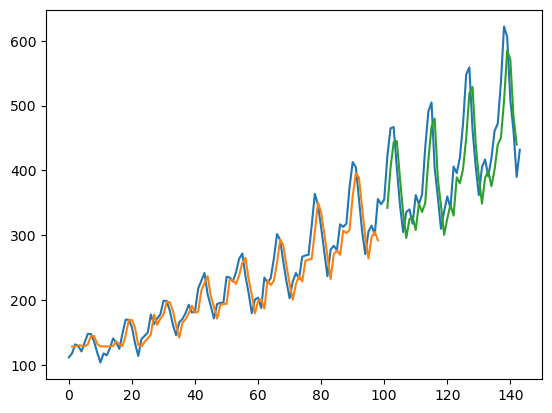

In [257]:
# make predictions
trainPredict = rnn.predict(X_train)
testPredict = rnn.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
rnn_y_pred = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = np.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mse(testY[0], rnn_y_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = rnn_y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

GRU MODEL

In [253]:
gru=Sequential()
gru.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1],1)))
gru.add(GRU(units=32, return_sequences=True))
gru.add(GRU(units=32, return_sequences=True))
gru.add(GRU(units=32))
gru.add(Dense(units=1))
gru.compile(optimizer='adam', loss='mean_squared_error')
gru.summary()

history_gru = gru.fit(X_train, y_train, epochs = 100, batch_size = 50, validation_split=0.2)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 1, 32)             3360      
                                                                 
 gru_9 (GRU)                 (None, 1, 32)             6336      
                                                                 
 gru_10 (GRU)                (None, 1, 32)             6336      
                                                                 
 gru_11 (GRU)                (None, 32)                6336      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 22,401
Trainable params: 22,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] 

2/2 [==============================] - 0s 3ms/step
Train Score: 24.74 RMSE
Test Score: 61.60 RMSE


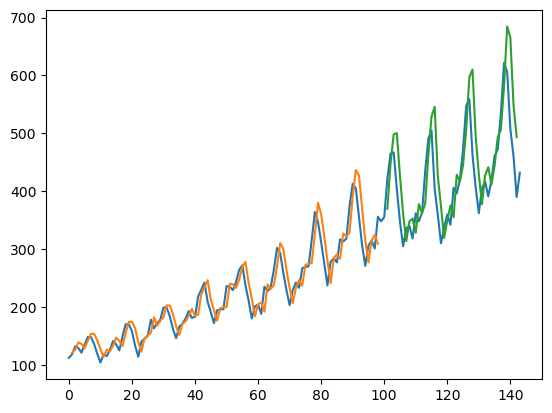

In [258]:
# make predictions
trainPredict = gru.predict(X_train)
testPredict = gru.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
gru_y_pred = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = np.sqrt(mse(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mse(testY[0], gru_y_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = gru_y_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

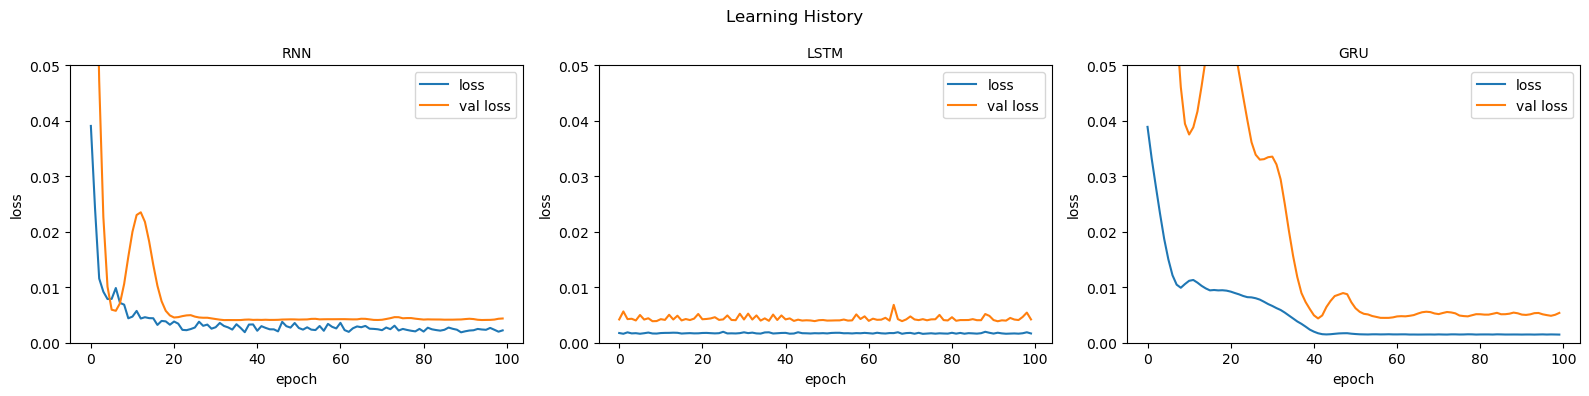

In [255]:
# Visualize Training History

# Set subplot subtitles
titles = ['RNN', 'LSTM', 'GRU']

# Create a list of prediction models
models = [history_rnn, history_LSTM, history_gru]

# Set the plot area
fig, ax = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)  

# Plot learning history
plt.suptitle('Learning History')
for i in range(0, 3):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i], fontsize=10) 
    plt.plot(models[i].history['loss'], label='loss')
    plt.plot(models[i].history['val_loss'], label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.ylim([0,0.05])

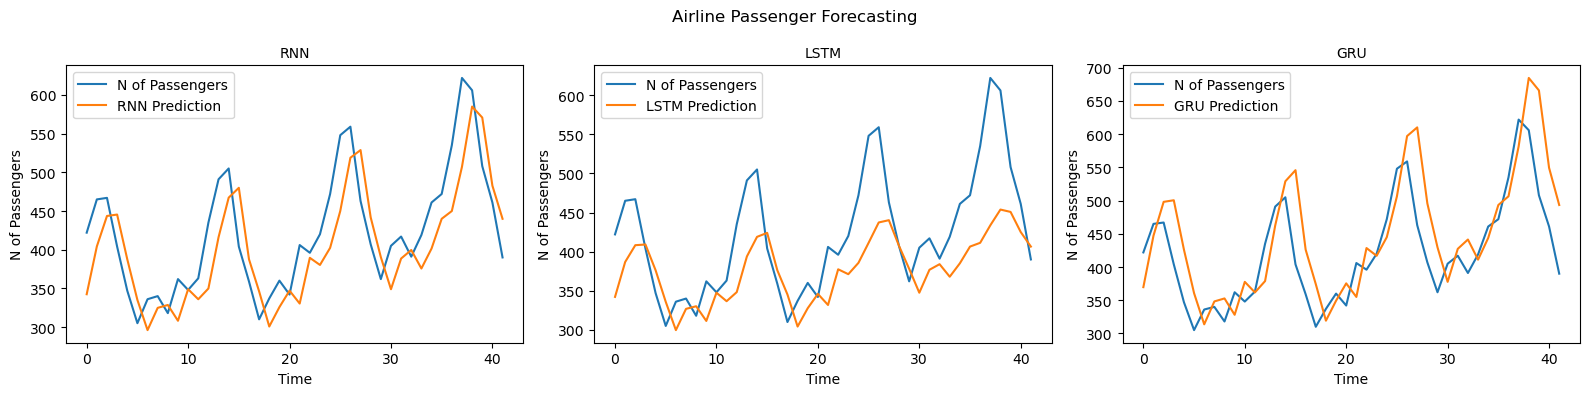

In [259]:
# Visualize Prediction Results

y_test = y_test.reshape(y_test.shape[0],1)
y_test = scaler.inverse_transform(y_test)
# Set subplot subtitles
titles = ['RNN', 'LSTM', 'GRU']

# Create a list of prediction models
models = [rnn_y_pred, lstm_y_pred, gru_y_pred]

# Set the plot area
fig, ax = plt.subplots(1, 3, figsize=(16,4), tight_layout=True)  

# Set the title
plt.suptitle('Airline Passenger Forecasting')

# Create and show subplots
for i in range(0, 3):
    plt.subplot(1, 3,i+1)
    plt.title(titles[i], fontsize=10) 
    plt.plot(y_test, label='N of Passengers')
    plt.plot(models[i], label=titles[i]+' Prediction')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('N of Passengers') 